In [56]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pickle
import json

# Statistical and Time Series libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Only for comparison
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Warnings
import warnings
warnings.filterwarnings('ignore')
import os.path as path
notebook_dir = path.dirname(path.abspath('__file__'))
# Get project root (parent of notebooks directory)
project_root = path.abspath(path.join(notebook_dir, '..', '..'))

# Define paths relative to project root
RAW_DATA_PATH = path.join(project_root, 'data', 'raw', 'flights_sample_3m.csv')
PROCESSED_DATA_PATH = path.join(project_root, 'data', 'processed')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [57]:
TS_PROCESSED_PATH = path.join(project_root, 'data', 'processed', 'ts_ready_flights')
TS_MODEL_PATH = path.join(project_root, 'models', 'ts')

# Create directories if they don't exist
os.makedirs(TS_MODEL_PATH, exist_ok=True)

print(f"Time Series processed data path: {TS_PROCESSED_PATH}")
print(f"Time Series model path: {TS_MODEL_PATH}")

# Display settings
pd.set_option('display.max_columns', None)
print("Libraries and paths configured.")

# Load the preprocessed time series data
def load_flight_data():
    """Load and preprocess flight data for hourly aggregation"""
    ts_data_path = os.path.join(TS_PROCESSED_PATH, 'complete_ts_preprocessed_flights.pkl')
    
    if os.path.exists(ts_data_path):
        print(f"Loading preprocessed data from {ts_data_path}")
        df = pd.read_pickle(ts_data_path)
    else:
        csv_path = os.path.join(TS_PROCESSED_PATH, 'complete_ts_preprocessed_flights.csv')
        if os.path.exists(csv_path):
            print(f"Pickle file not found. Loading from CSV: {csv_path}")
            df = pd.read_csv(csv_path)
            # Convert date columns to datetime
            date_columns = [col for col in df.columns if 'DATE' in col.upper() or 'TIME' in col.upper()]
            for col in date_columns:
                df[col] = pd.to_datetime(df[col])
        else:
            raise FileNotFoundError(f"Preprocessed data files not found in {TS_PROCESSED_PATH}")
    
    return df

df = load_flight_data()

# Display basic information
print("\nDataset information:")
print(f"Shape: {df.shape}")
print(f"Date range: {df['FL_DATE'].min()} to {df['FL_DATE'].max()}")
print("\nFirst few rows of the data:")
display(df.head())

Time Series processed data path: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights
Time Series model path: c:\xampp\htdocs\Forecasting_Flights-DataScience\models\ts
Libraries and paths configured.
Loading preprocessed data from c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\complete_ts_preprocessed_flights.pkl

Dataset information:
Shape: (500000, 92)
Date range: 2019-01-01 00:00:00 to 2023-08-31 00:00:00

First few rows of the data:


,FL_DATE,ORIGIN_0,ORIGIN_1,ORIGIN_2,ORIGIN_3,ORIGIN_4,ORIGIN_5,ORIGIN_6,ORIGIN_7,ORIGIN_8,DEST_0,DEST_1,DEST_2,DEST_3,DEST_4,DEST_5,DEST_6,DEST_7,DEST_8,DEP_DELAY,TAXI_OUT,TAXI_IN,DISTANCE,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,SEASON,DEP_HOUR,TIME_OF_DAY,DATETIME,is_holiday,is_holiday_season,CRS_DEP_TIME_sin,CRS_DEP_TIME_cos,DEP_TIME_sin,DEP_TIME_cos,CRS_ARR_TIME_sin,CRS_ARR_TIME_cos,ARR_TIME_sin,ARR_TIME_cos,WHEELS_ON_sin,WHEELS_ON_cos,WHEELS_OFF_sin,WHEELS_OFF_cos,AIRLINE_Allegiant Air,AIRLINE_American Airlines Inc.,AIRLINE_Delta Air Lines Inc.,AIRLINE_Endeavor Air Inc.,AIRLINE_Envoy Air,AIRLINE_ExpressJet Airlines LLC d/b/a aha!,AIRLINE_Frontier Airlines Inc.,AIRLINE_Hawaiian Airlines Inc.,AIRLINE_Horizon Air,AIRLINE_JetBlue Airways,AIRLINE_Mesa Airlines Inc.,AIRLINE_PSA Airlines Inc.,AIRLINE_Republic Airline,AIRLINE_SkyWest Airlines Inc.,AIRLINE_Southwest Airlines Co.,AIRLINE_Spirit Air Lines,AIRLINE_United Air Lines Inc.,DIVERTED_1,IS_HOLIDAY_SEASON_1,DEP_DELAY_lag1,DEP_DELAY_lag2,DEP_DELAY_lag3,DEP_DELAY_lag7,DEP_DELAY_lag14,DEP_DELAY_lag21,DEP_DELAY_lag28,DEP_DELAY_roll_mean3,DEP_DELAY_roll_std3,DEP_DELAY_roll_min3,DEP_DELAY_roll_max3,DEP_DELAY_roll_median3,DEP_DELAY_roll_mean7,DEP_DELAY_roll_std7,DEP_DELAY_roll_min7,DEP_DELAY_roll_max7,DEP_DELAY_roll_median7,DEP_DELAY_roll_mean14,DEP_DELAY_roll_std14,DEP_DELAY_roll_min14,DEP_DELAY_roll_max14,DEP_DELAY_roll_median14,DEP_DELAY_roll_mean28,DEP_DELAY_roll_std28,DEP_DELAY_roll_min28,DEP_DELAY_roll_max28,DEP_DELAY_roll_median28
0,2019-01-09,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0.0,0.500,-0.400000,0.603916,-0.666667,-1,-1.0,-0.466667,-0.25,-2,-0.250,0.5,2019-01-09 11:00:00,0.0,0,0.210591,0.262977,0.226042,0.286094,0.124709,0.098319,-0.215623,-0.263206,-0.202627,-0.273817,0.193470,-0.581168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-11-19,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.0,-0.750,4.240919,1.106928,0.333333,2,1.0,0.200000,0.50,1,1.000,0.0,2022-11-19 21:00:00,0.0,1,-1.721575,-0.381857,-1.578544,-0.390009,-1.302252,-0.004021,0.203110,1.057270,0.050969,1.056205,-0.222959,1.309765,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-07-22,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,6.0,0.625,-0.200000,0.024096,0.333333,1,0.2,0.400000,0.25,0,-0.500,0.5,2022-07-22 09:00:00,0.0,0,0.273679,0.444072,0.293700,0.606425,0.269188,0.341391,0.195180,-0.438246,0.206840,-0.448664,0.523056,-0.482284,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.464102,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-03-06,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.0,1.500,0.600000,1.393072,0.666667,-1,-0.6,-0.666667,-0.75,-1,0.375,-0.5,2023-03-06 16:00:00,0.0,0,-0.510912,-0.324800,-0.460323,-0.321316,-0.393868,-0.291013,-0.502110,0.484495,-0.502461,0.474875,-0.434537,0.097618,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.464102,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-07-31,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,147.0,0.000,-0.600000,-0.727410,-0.666667,1,0.2,1.000000,-0.25,0,-0.375,0.5,2019-07-31 10:00:00,0.0,0,0.288717,0.552742,0.112483,0.093015,0.392627,0.699559,0.044473,-0.398250,0.050969,-0.407722,0.065285,-0.554855,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,51.0,83.192548,0.0,147.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Starting data preparation...
Preparing robust hourly time series for ARIMA modeling...
Available columns: ['FL_DATE', 'ORIGIN_0', 'ORIGIN_1', 'ORIGIN_2', 'ORIGIN_3', 'ORIGIN_4', 'ORIGIN_5', 'ORIGIN_6', 'ORIGIN_7', 'ORIGIN_8', 'DEST_0', 'DEST_1', 'DEST_2', 'DEST_3', 'DEST_4', 'DEST_5', 'DEST_6', 'DEST_7', 'DEST_8', 'DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 'DISTANCE', 'YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'SEASON', 'DEP_HOUR', 'TIME_OF_DAY', 'DATETIME', 'is_holiday', 'is_holiday_season', 'CRS_DEP_TIME_sin', 'CRS_DEP_TIME_cos', 'DEP_TIME_sin', 'DEP_TIME_cos', 'CRS_ARR_TIME_sin', 'CRS_ARR_TIME_cos', 'ARR_TIME_sin', 'ARR_TIME_cos', 'WHEELS_ON_sin', 'WHEELS_ON_cos', 'WHEELS_OFF_sin', 'WHEELS_OFF_cos', 'AIRLINE_Allegiant Air', 'AIRLINE_American Airlines Inc.', 'AIRLINE_Delta Air Lines Inc.', 'AIRLINE_Endeavor Air Inc.', 'AIRLINE_Envoy Air', 'AIRLINE_ExpressJet Airlines LLC d/b/a aha!', 'AIRLINE_Frontier Airlines Inc.', 'AIRLINE_Hawaiian Airlines Inc.', 'AIRLINE_Horizon Air', 

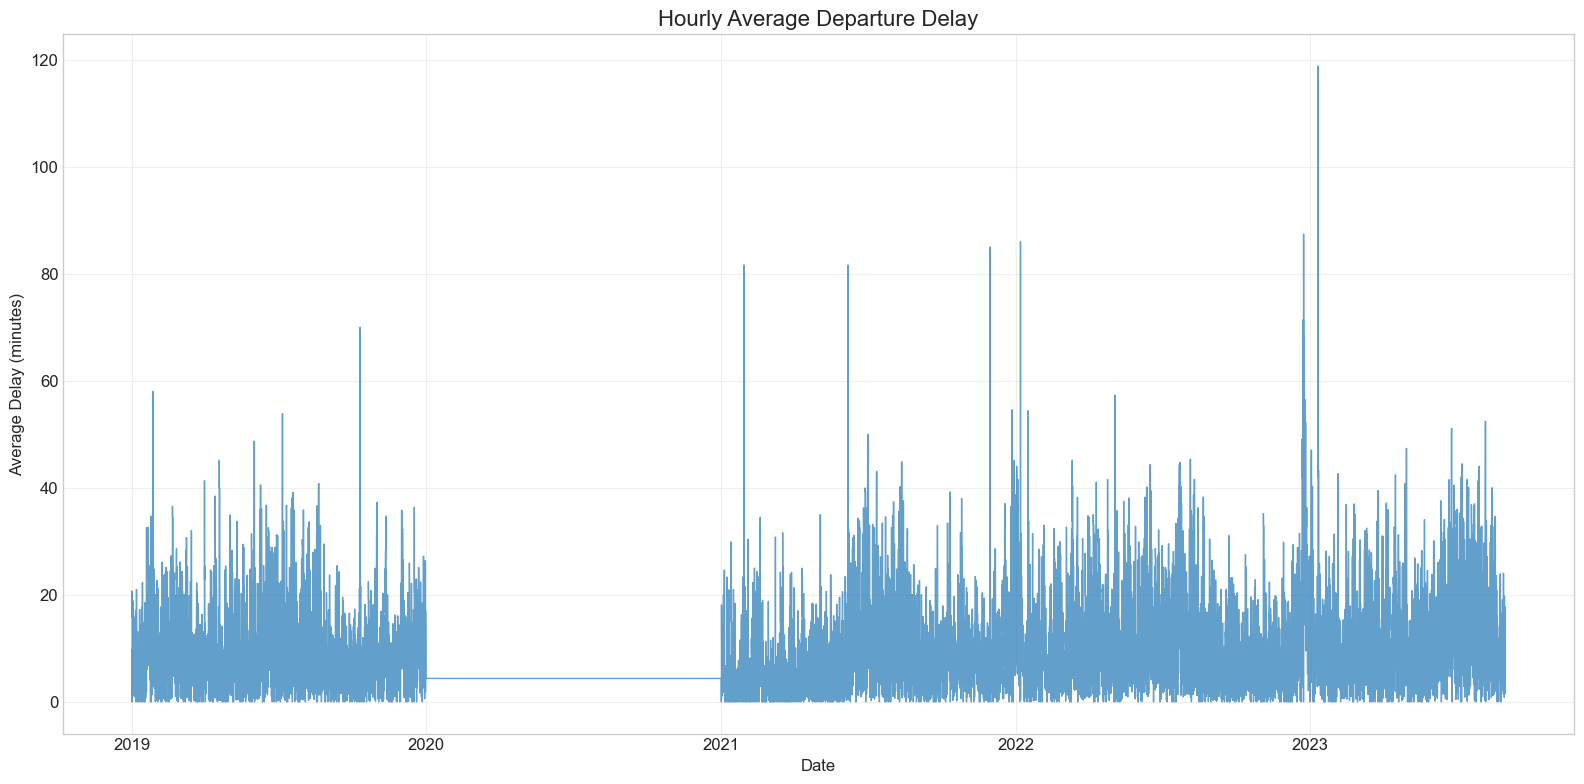

In [58]:
def prepare_hourly_arima_data(df, target_col='DEP_DELAY'):
    """
    Robust hourly time series preparation with comprehensive error handling
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame
    target_col : str
        The target column to use for time series modeling
    
    Returns:
    --------
    pd.Series
        Hourly time series with datetime index
    """
    print("Preparing robust hourly time series for ARIMA modeling...")
    
    # Create a copy to avoid modifying original data
    df_processed = df.copy()
    
    # Check available time-related columns
    available_columns = df_processed.columns.tolist()
    print(f"Available columns: {available_columns}")
    
    # Handle time feature extraction
    if 'CRS_DEP_TIME' in df_processed.columns:
        print("Processing CRS_DEP_TIME column...")
        
        # Convert to datetime if not already
        if not pd.api.types.is_datetime64_any_dtype(df_processed['CRS_DEP_TIME']):
            try:
                # Handle numeric format (e.g., 800 for 8:00, 1430 for 14:30)
                df_processed['CRS_DEP_TIME'] = df_processed['CRS_DEP_TIME'].apply(
                    lambda x: pd.to_datetime(str(int(x)).zfill(4), format='%H%M' if pd.notnull(x) else pd.NaT
                ))
            except Exception as e:
                print(f"Could not parse CRS_DEP_TIME as datetime: {str(e)}")
                # Fall back to string parsing
                try:
                    df_processed['CRS_DEP_TIME'] = pd.to_datetime(df_processed['CRS_DEP_TIME'])
                except:
                    raise ValueError("Could not parse CRS_DEP_TIME column in any format")
        
        # Extract hour safely
        df_processed['HOUR'] = df_processed['CRS_DEP_TIME'].dt.hour
        
    elif all(col in df_processed.columns for col in ['CRS_DEP_TIME_sin', 'CRS_DEP_TIME_cos']):
        print("Processing cyclic time features (sin/cos)...")
        
        # Convert back to hours from sin/cos representation
        with np.errstate(invalid='ignore'):  # Suppress NaN warnings
            hours_rad = np.arccos(df_processed['CRS_DEP_TIME_cos'])
            hours = hours_rad * 12 / np.pi  # Convert to 0-24 scale
            
            # Handle NaN/inf values safely
            hours = np.nan_to_num(hours, nan=0.0, posinf=24.0, neginf=0.0)
            hours = np.clip(hours, 0, 24)
            
            df_processed['HOUR'] = np.round(hours).astype(int)
            
    else:
        raise KeyError("DataFrame must contain either CRS_DEP_TIME or both CRS_DEP_TIME_sin and CRS_DEP_TIME_cos columns")
    
    # Validate we have hours
    if 'HOUR' not in df_processed.columns:
        raise ValueError("Failed to extract hour information from available columns")
    
    # Clean hour values (0-23)
    df_processed['HOUR'] = df_processed['HOUR'].clip(0, 23)
    
    # Create datetime index with both date and hour
    print("Creating datetime index...")
    try:
        df_processed['DATETIME'] = pd.to_datetime(df_processed['FL_DATE']) + pd.to_timedelta(df_processed['HOUR'], unit='h')
    except Exception as e:
        raise ValueError(f"Could not create datetime index: {str(e)}")
    
    # Group by datetime and calculate mean delay
    print("Aggregating hourly data...")
    hourly_ts = df_processed.groupby('DATETIME')[target_col].mean()
    
    # Create complete hourly index to fill missing hours
    print("Creating complete time index...")
    try:
        min_date = df_processed['DATETIME'].min().floor('H')
        max_date = df_processed['DATETIME'].max().ceil('H')
        full_index = pd.date_range(start=min_date, end=max_date, freq='H')
        hourly_ts = hourly_ts.reindex(full_index)
    except Exception as e:
        raise ValueError(f"Could not create complete time index: {str(e)}")
    
    # Fill missing values safely
    print("Handling missing values...")
    hourly_ts = hourly_ts.fillna(method='ffill').fillna(method='bfill').fillna(0)
    
    return hourly_ts

# Create hourly time series with comprehensive error handling
try:
    print("\nStarting data preparation...")
    hourly_delays = prepare_hourly_arima_data(df, target_col='DEP_DELAY')
    
    # Plot the hourly time series
    print("\nPlotting results...")
    plt.figure(figsize=(16, 8))
    plt.plot(hourly_delays.index, hourly_delays, linewidth=1, alpha=0.7)
    plt.title('Hourly Average Departure Delay', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Average Delay (minutes)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"\nError encountered: {str(e)}")
    print("\nDebugging information:")
    print(f"DataFrame shape: {df.shape}")
    print("Sample of FL_DATE column:")
    print(df['FL_DATE'].head())
    
    if 'CRS_DEP_TIME' in df.columns:
        print("\nSample of CRS_DEP_TIME column:")
        print(df['CRS_DEP_TIME'].head())
        print(f"CRS_DEP_TIME dtype: {df['CRS_DEP_TIME'].dtype}")
    
    if all(col in df.columns for col in ['CRS_DEP_TIME_sin', 'CRS_DEP_TIME_cos']):
        print("\nSample of cyclic time features:")
        print(df[['CRS_DEP_TIME_sin', 'CRS_DEP_TIME_cos']].head())
    
    print("\nPlease check your input data format and try again.")

Checking stationarity and applying differencing...
ADF test with d=0: p-value = 0.0000
Series is stationary at d=0

ACF and PACF plots for ARIMA parameter selection:


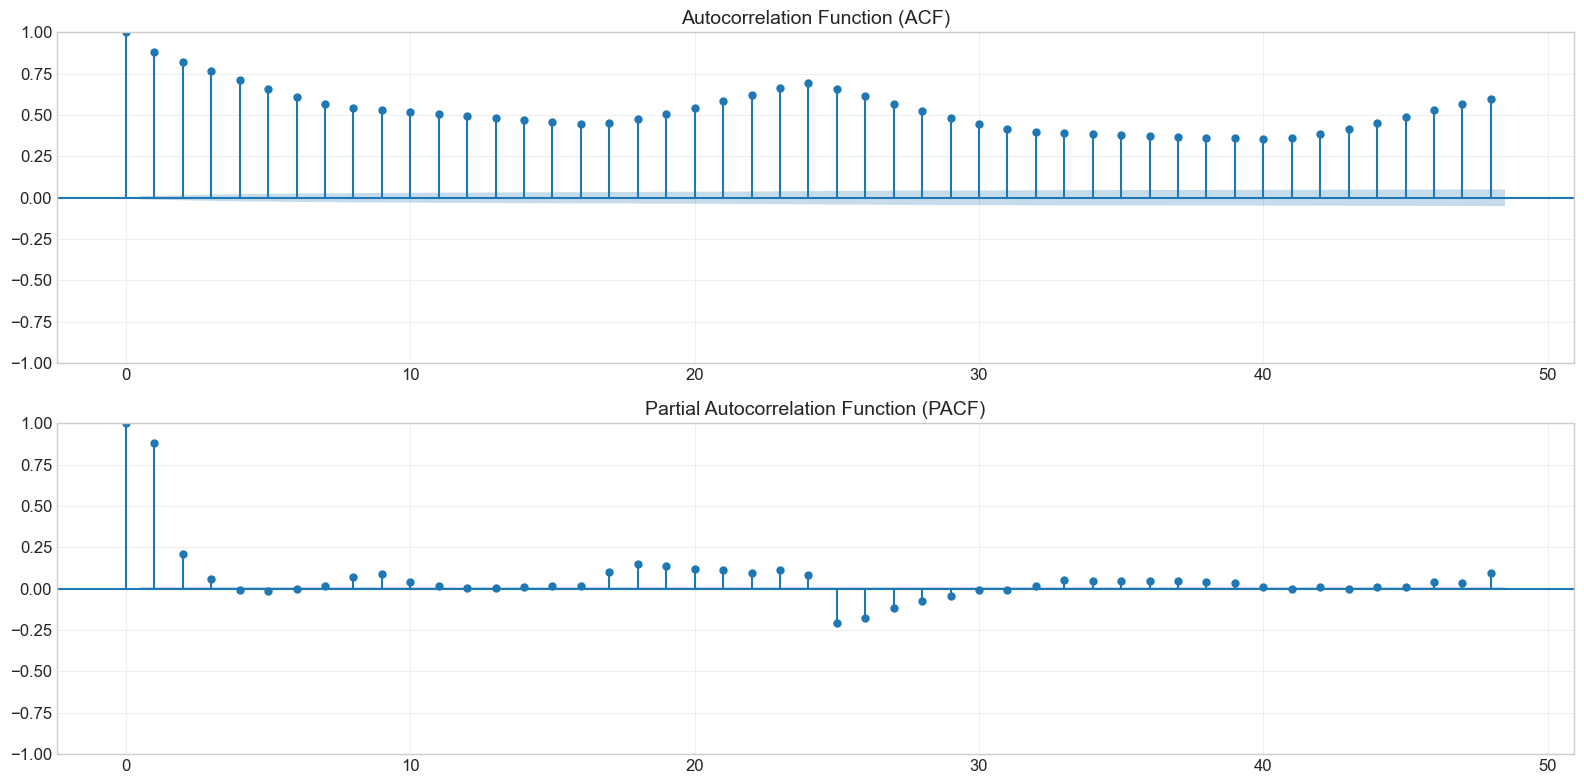

In [69]:
def make_stationary(ts, max_diff=2):
    """
    Make time series stationary through differencing
    
    Parameters:
    -----------
    ts : pd.Series
        Time series data
    max_diff : int
        Maximum differencing order to try
    
    Returns:
    --------
    tuple
        (stationary_series, d) where d is the differencing order
    """
    print("Checking stationarity and applying differencing...")
    
    current_ts = ts.copy()
    d = 0
    
    for i in range(max_diff + 1):
        # Perform ADF test
        result = adfuller(current_ts.dropna())
        p_value = result[1]
        
        print(f"ADF test with d={d}: p-value = {p_value:.4f}")
        
        if p_value <= 0.05:
            print(f"Series is stationary at d={d}")
            return current_ts, d
        
        # Apply differencing if not stationary
        if i < max_diff:
            current_ts = current_ts.diff().dropna()
            d += 1
            print(f"Applying differencing (d={d})")
    
    print(f"Warning: Series not stationary after {max_diff} differences")
    return current_ts, d

# Make the series stationary
stationary_delays, d = make_stationary(hourly_delays, max_diff=2)

# Plot ACF and PACF to determine AR and MA orders
def plot_acf_pacf(ts, lags=48):
    """
    Plot ACF and PACF to help identify AR and MA orders
    
    Parameters:
    -----------
    ts : pd.Series
        Time series data
    lags : int
        Number of lags to plot
    """
    plt.figure(figsize=(16, 8))
    
    plt.subplot(211)
    plot_acf(ts, lags=lags, alpha=0.05, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF)', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(212)
    plot_pacf(ts, lags=lags, alpha=0.05, method='ols', ax=plt.gca())
    plt.title('Partial Autocorrelation Function (PACF)', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot ACF and PACF
print("\nACF and PACF plots for ARIMA parameter selection:")
plot_acf_pacf(stationary_delays, lags=48)


Training set: 28616 samples (2019-01-01 00:00:00 to 2022-04-07 07:00:00)
Test set: 12265 samples (2022-04-07 08:00:00 to 2023-08-31 08:00:00)


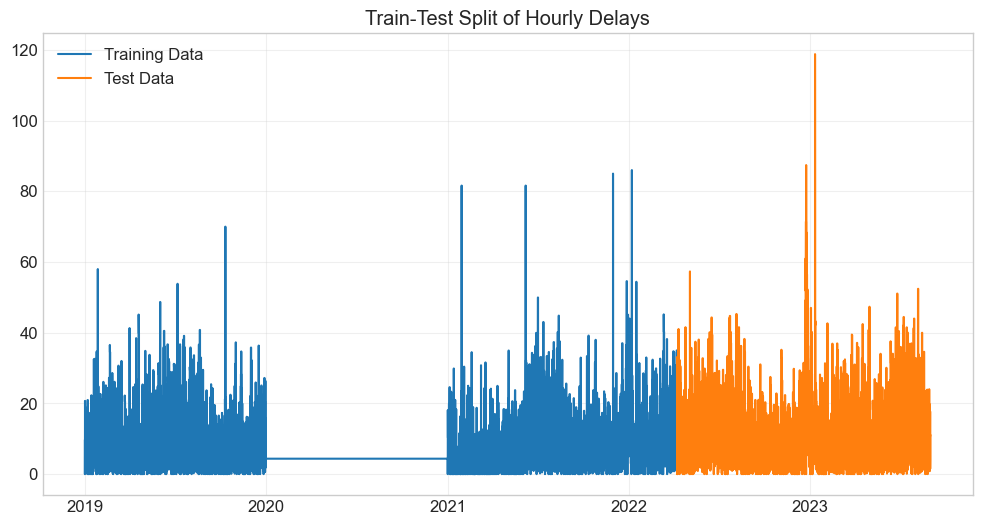

In [51]:
train_size = int(len(hourly_delays) * 0.7)
train, test = hourly_delays.iloc[:train_size], hourly_delays.iloc[train_size:]

print(f"Training set: {len(train)} samples ({train.index.min()} to {train.index.max()})")
print(f"Test set: {len(test)} samples ({test.index.min()} to {test.index.max()})")

# Plot train-test split
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.title('Train-Test Split of Hourly Delays')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Performing grid search over 16 ARIMA combinations...
ARIMA(0,0,0) - AIC: 302912.86
ARIMA(0,0,1) - AIC: 274458.02
ARIMA(0,0,2) - AIC: 261651.21
ARIMA(0,0,3) - AIC: 254421.74
ARIMA(1,0,0) - AIC: 242420.00
ARIMA(1,0,1) - AIC: 240469.00
ARIMA(1,0,2) - AIC: 240469.24
ARIMA(1,0,3) - AIC: 240443.29
ARIMA(2,0,0) - AIC: 240584.91
ARIMA(2,0,1) - AIC: 240469.55
ARIMA(2,0,2) - AIC: 240466.96
ARIMA(2,0,3) - AIC: 240444.74
ARIMA(3,0,0) - AIC: 240451.83
ARIMA(3,0,1) - AIC: 240452.68
ARIMA(3,0,2) - AIC: 240426.22
ARIMA(3,0,3) - AIC: 237913.80

Top 5 ARIMA Models by AIC:
    p  d  q            aic
15  3  0  3  237913.802194
14  3  0  2  240426.216831
7   1  0  3  240443.292397
11  2  0  3  240444.738986
12  3  0  0  240451.833984

Fitting best ARIMA model: (3, 0, 3) with AIC: 237913.80
                               SARIMAX Results                                
Dep. Variable:              DEP_DELAY   No. Observations:                40881
Model:                 ARIMA(3, 0, 3)   Log Likelihood        

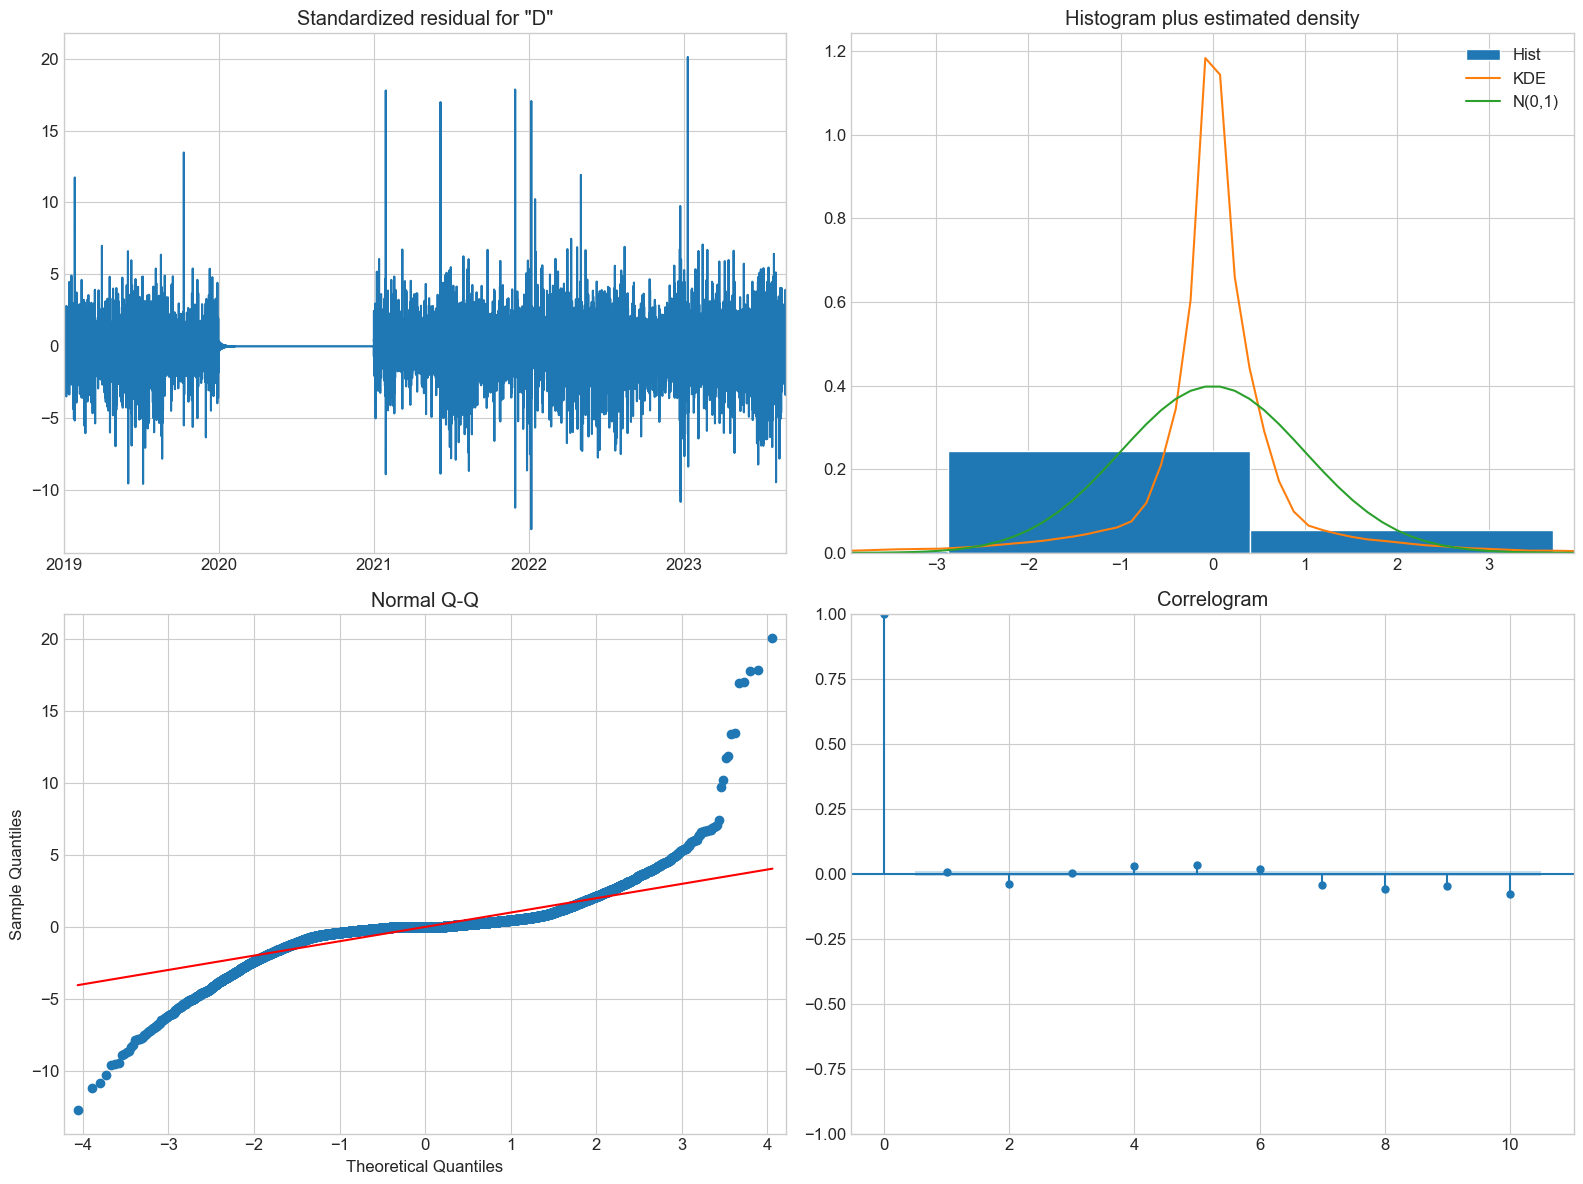

In [60]:
def arima_grid_search(ts, p_range, d, q_range):
    """
    Manual grid search for ARIMA parameters
    
    Parameters:
    -----------
    ts : pd.Series
        Time series data
    p_range : range
        Range for AR order (p)
    d : int
        Differencing order (already determined)
    q_range : range
        Range for MA order (q)
    
    Returns:
    --------
    tuple
        (best_order, best_aic, results_df)
    """
    best_aic = float('inf')
    best_order = None
    results = []
    
    total_combinations = len(p_range) * len(q_range)
    print(f"Performing grid search over {total_combinations} ARIMA combinations...")
    
    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(ts, order=(p, d, q))
                model_fit = model.fit()
                aic = model_fit.aic
                
                results.append({
                    'p': p,
                    'd': d,
                    'q': q,
                    'aic': aic
                })
                
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    
                print(f"ARIMA({p},{d},{q}) - AIC: {aic:.2f}")
                
            except Exception as e:
                print(f"Failed to fit ARIMA({p},{d},{q}): {str(e)}")
                continue
    
    # Create results DataFrame
    results_df = pd.DataFrame(results).sort_values('aic')
    
    print("\nTop 5 ARIMA Models by AIC:")
    print(results_df.head())
    
    return best_order, best_aic, results_df

# Define parameter ranges
p_range = range(0, 4)  # AR order
q_range = range(0, 4)  # MA order

# Run grid search
best_order, best_aic, results_df = arima_grid_search(
    hourly_delays,
    p_range=p_range,
    d=d,
    q_range=q_range
)

# Fit the best ARIMA model
print(f"\nFitting best ARIMA model: {best_order} with AIC: {best_aic:.2f}")
best_model = ARIMA(hourly_delays, order=best_order).fit()

# Model summary
print(best_model.summary())

# Diagnostic plots
best_model.plot_diagnostics(figsize=(16, 12))
plt.tight_layout()
plt.show()


In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

def arima_ts_validate(ts, order, n_splits=3, test_size=24):
    """
    Time series cross-validation for ARIMA model
    
    Parameters:
    -----------
    ts : pd.Series
        Time series data
    order : tuple
        (p, d, q) ARIMA order
    n_splits : int
        Number of cross-validation splits
    test_size : int
        Size of test set in each split
    
    Returns:
    --------
    dict
        Dictionary of validation metrics
    """
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
    
    metrics = {
        'rmse': [],
        'mae': [],
        'mape': [],
        'r2': []
    }
    
    print(f"Performing {n_splits}-fold time series cross-validation...")
    
    for train_index, test_index in tscv.split(ts):
        # Split data
        train = ts.iloc[train_index]
        test = ts.iloc[test_index]
        
        # Fit model
        model = ARIMA(train, order=order).fit()
        
        # Forecast
        forecast = model.get_forecast(steps=len(test))
        forecast_mean = forecast.predicted_mean
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(test, forecast_mean))
        mae = mean_absolute_error(test, forecast_mean)
        mape = np.mean(np.abs((test - forecast_mean) / test)) * 100
        r2 = r2_score(test, forecast_mean)
        
        # Store metrics
        metrics['rmse'].append(rmse)
        metrics['mae'].append(mae)
        metrics['mape'].append(mape)
        metrics['r2'].append(r2)
    
    # Calculate mean metrics
    mean_metrics = {k: np.mean(v) for k, v in metrics.items()}
    
    print("\nCross-Validation Results:")
    print(f"Average RMSE: {mean_metrics['rmse']:.2f}")
    print(f"Average MAE: {mean_metrics['mae']:.2f}")
    print(f"Average MAPE: {mean_metrics['mape']:.2f}%")
    print(f"Average R²: {mean_metrics['r2']:.4f}")
    
    return mean_metrics

# Perform cross-validation
cv_metrics = arima_ts_validate(
    hourly_delays,
    order=best_order,
    n_splits=3,
    test_size=24
)

Performing 3-fold time series cross-validation...

Cross-Validation Results:
Average RMSE: 4.45
Average MAE: 3.61
Average MAPE: 72.07%
Average R²: -0.1577


Test RMSE: 11.41
Test MAE: 8.34
Test MAPE: nan%
Test R²: -0.1738


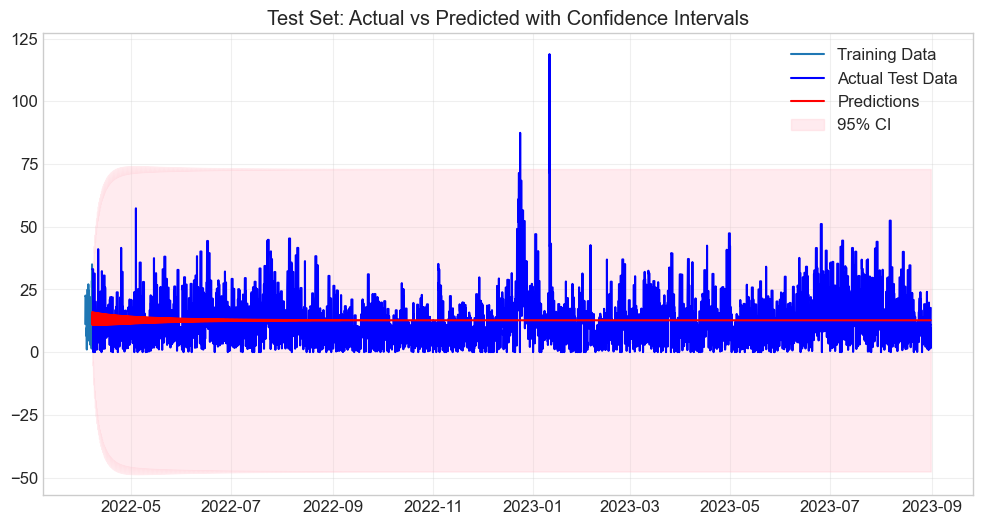

In [62]:
test_forecast = best_model.get_forecast(steps=len(test))
test_forecast_mean = test_forecast.predicted_mean
conf_int = test_forecast.conf_int()

# Calculate metrics
test_rmse = np.sqrt(mean_squared_error(test, test_forecast_mean))
test_mae = mean_absolute_error(test, test_forecast_mean)
test_mape = np.mean(np.abs((test - test_forecast_mean) / test)) * 100
test_r2 = r2_score(test, test_forecast_mean)

print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape:.2f}%")
print(f"Test R²: {test_r2:.4f}")

# Plot test predictions
plt.figure(figsize=(12, 6))
plt.plot(train.index[-100:], train.values[-100:], label='Training Data')
plt.plot(test.index, test, label='Actual Test Data', color='blue')
plt.plot(test.index, test_forecast_mean, label='Predictions', color='red')
plt.fill_between(test.index,
                conf_int.iloc[:, 0],
                conf_int.iloc[:, 1],
                color='pink', alpha=0.3, label='95% CI')
plt.title('Test Set: Actual vs Predicted with Confidence Intervals')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

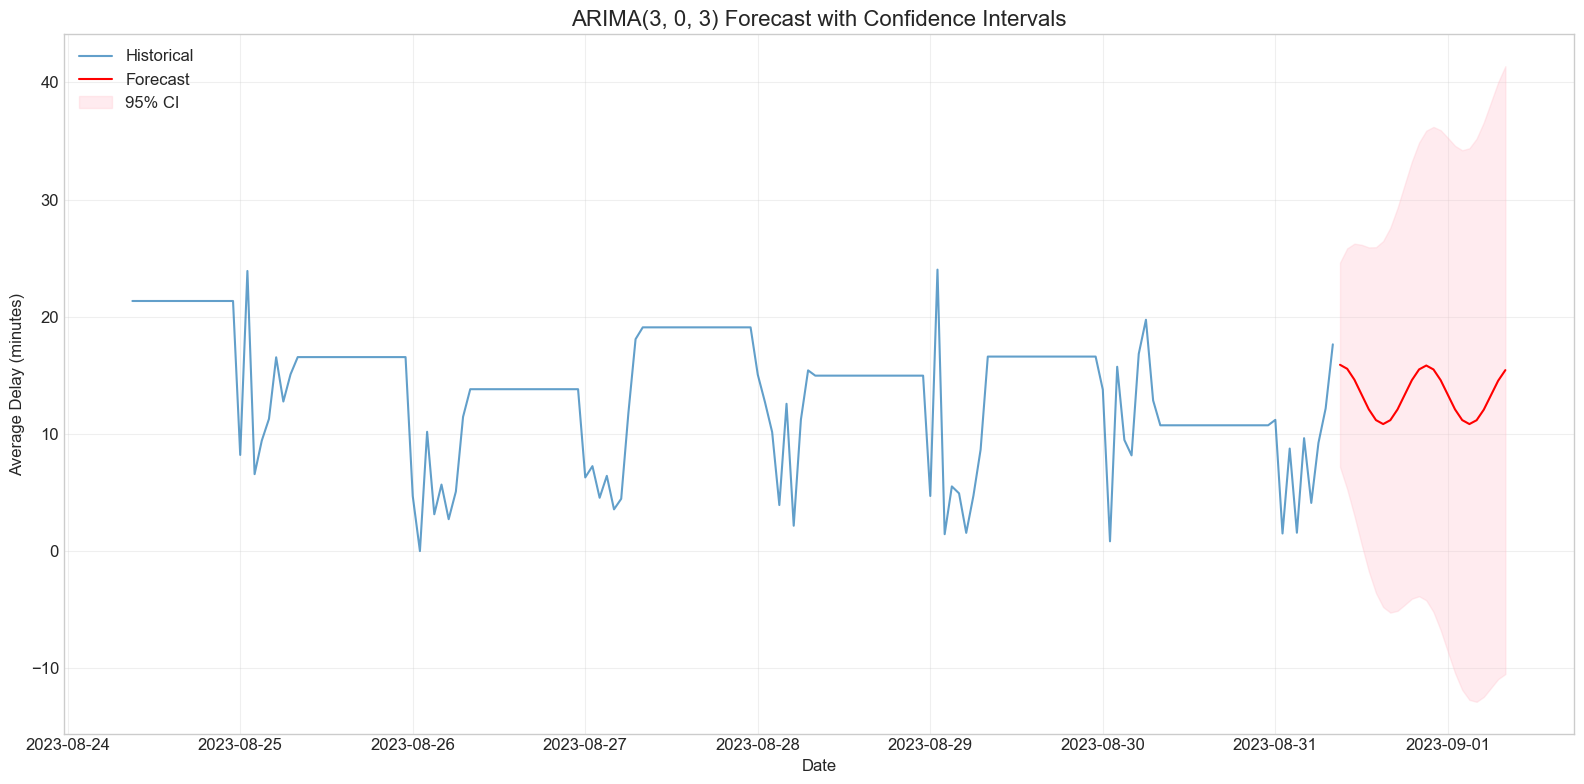


24-Hour Forecast:


,Forecast,Lower_CI,Upper_CI
2023-08-31 09:00:00,15.901475,7.177620,24.625331
2023-08-31 10:00:00,15.558026,5.279130,25.836922
2023-08-31 11:00:00,14.629668,3.019528,26.239807
2023-08-31 12:00:00,13.365195,0.588117,26.142273
2023-08-31 13:00:00,12.102785,-1.713478,25.919048
2023-08-31 14:00:00,11.179366,-3.576086,25.934817
2023-08-31 15:00:00,10.840503,-4.777762,26.458768
2023-08-31 16:00:00,11.174913,-5.250252,27.600077
2023-08-31 17:00:00,12.091058,-5.101905,29.284020
2023-08-31 18:00:00,13.342005,-4.591952,31.275961


In [49]:
def arima_forecast(model, steps=24, plot=True):
    """
    Generate forecasts from ARIMA model
    
    Parameters:
    -----------
    model : fitted ARIMA model
    steps : int
        Number of steps to forecast
    plot : bool
        Whether to plot the forecast
    
    Returns:
    --------
    pd.DataFrame
        Forecast results with confidence intervals
    """
    # Generate forecast
    forecast = model.get_forecast(steps=steps)
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()
    
    # Create DataFrame
    forecast_df = pd.DataFrame({
        'Forecast': forecast_mean,
        'Lower_CI': conf_int.iloc[:, 0],
        'Upper_CI': conf_int.iloc[:, 1]
    })
    
    if plot:
        # Plot settings
        plt.figure(figsize=(16, 8))
        
        # Plot historical data
        history = model.data.orig_endog
        plt.plot(history.index[-24*7:], history[-24*7:], label='Historical', alpha=0.7)
        
        # Plot forecast
        plt.plot(forecast_mean.index, forecast_mean, color='red', label='Forecast')
        
        # Plot confidence intervals
        plt.fill_between(
            forecast_mean.index,
            conf_int.iloc[:, 0],
            conf_int.iloc[:, 1],
            color='pink', alpha=0.3, label='95% CI'
        )
        
        # Formatting
        plt.title(f'ARIMA{best_order} Forecast with Confidence Intervals', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Average Delay (minutes)', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return forecast_df

# Generate 24-hour forecast
forecast_df = arima_forecast(best_model, steps=24)

# Display forecast
print("\n24-Hour Forecast:")
display(forecast_df)